In [99]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
import numpy as np
from scipy.stats import rankdata
import pandas as pd
import pickle
import lightgbm
import os
from lime import lime_tabular
import sys
sys.path.append('..')
from lirme_v2 import LIRME
from sklearn.utils import shuffle
from scipy.stats import spearmanr, kendalltau
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
sys.path.append('..')
from get_exp_new import lime_exp, shap_exp, random_exp, grad_exp
from greedy_score import Greedy
from sklearn.metrics import ndcg_score, jaccard_score
import matplotlib.pyplot as plt
import seaborn as sns
from evaluation import get_fidelity_ltr,validity_completeness,  get_explain_ndcg, validity_completeness, get_infidelity, get_fidelity_ltr, get_dpff, summarize
from tabulate import tabulate

In [101]:
color_list = {
    'rank_lime': 'blue',
    'lirme': 'gold',
    'lime': 'darkorange',
    'shap': 'brown',
    'exs_top_k_rank': 'cyan', 
    'exs_top_k_binary': 'lightgreen', 
    'exs_score': 'magenta',
    'random': 'black',
    'pmi': 'turquoise',
    'greedy_score': 'blue',
    'rank_lime': 'green'
}

In [102]:
def min_max(v):
    return (v - v.min()) / (v.max() - v.min())

In [103]:
def evaluate(exps_file, test):
    eval = {'dpff': {}, 'fidelity_ltr': {}, 'validity': {}, 'completeness': {}, 'infidelity': {}, 'explain_ndcg': {}}
    exp_names = ['pmi', 'greedy_score', 'rank_lime', 'lime', 'shap', 'lirme', 'exs_score', 'exs_top_k_binary', 'exs_top_k_rank', 'random']
    measure_keys = ['dpff', 'fidelity_ltr', 'validity', 'completeness', 'infidelity', 'explain_ndcg']
    
    for exp_name in exp_names:
        for m in measure_keys:
            eval[m][exp_name] = []
        
    for key in exps_file.keys():
        doc_values = test[key]
        for exp_name in exp_names:
            exp_val = exps_file[key][exp_name].flatten()
            exp_val = min_max(exp_val)
            
            eval['fidelity_ltr'][exp_name].append(get_fidelity_ltr(exp_val, doc_values, ranker.predict))
            eval['validity'][exp_name].append(validity_completeness(exp_val, doc_values, ranker.predict, 'validity'))
            eval['completeness'][exp_name].append(validity_completeness(exp_val, doc_values, ranker.predict, 'completeness'))
            eval['infidelity'][exp_name].append(get_infidelity(exp_val, doc_values, ranker.predict, background))
            eval['explain_ndcg'][exp_name].append(get_explain_ndcg(exp_val, doc_values, ranker.predict))

            eval['fidelity_ltr'][exp_name].append(get_fidelity_ltr(exp_val, doc_values, ranker.predict))
            eval['dpff'][exp_name].append(get_dpff(exp_val, doc_values, ranker))
    
    return eval

In [104]:
dataset_name = 'mq2008'

In [105]:
exps = pickle.load( open( "./exps/{}_pointwise_exps_v3.p".format(dataset_name), "rb"))
q_exps = pickle.load( open( "./exps/{}_listwise_exps_v3.p".format(dataset_name), "rb" ) )
test_sample = pickle.load( open( "./data/{}_test_sample_v2.p".format(dataset_name), "rb" ) )
background_dict = pickle.load( open( "./data/{}_background_v3.p".format(dataset_name), "rb" ) )

In [139]:
res = {}

for q in exps.keys():
    res[q] = {}
    for p_exp in exps[q]:
        res[q][p_exp] = np.sum(np.array(exps[q][p_exp]), axis=0)
for q in res.keys():
    for e in res[q]:
        q_exps[q][e] = res[q][e]
queries = list(q_exps.keys())
exp_names = list(q_exps[queries[0]].keys())
ranker = lightgbm.Booster(model_file='./models/lmart_{}_v2.txt'.format(dataset_name))

In [107]:
background = []
for q in background_dict:
    background.extend(background_dict[q])
    
background = np.array(background).reshape(-1, test_sample[list(test_sample.keys())[0]].shape[1])

In [108]:
#eval = evaluate(q_exps, test_sample)
#pickle.dump(eval, open( f"./{dataset_name}_evaluate_summary_v3_normalized.p", "wb" ) )

### Loading

In [109]:
def load_and_summarize(file_name):
    eval_ = pickle.load( open( file_name, "rb" ) )
    summary_ = summarize(eval_)
    summary_df_ = pd.DataFrame(summary_)
    summary_df_ = summary_df_.reindex(columns=['dpff', 'fidelity_ltr', 'explain_ndcg', 'completeness', 'validity', 'infidelity'])
    summary_df_ = summary_df_.reindex(index=['pmi', 'greedy_score', 'rank_lime', 'lirme',
           'exs_score', 'exs_top_k_binary', 'exs_top_k_rank', 'lime', 'shap', 'random'])
    summary_df_.columns = ['FF', 'Fidelity', 'Explain NDCG', 'Completeness', 'Validity', 'Infidelity']
    summary_df_.index = ['PMI', 'Greedy Score', 'RankLIME', 'LIRME', 'EXS (S)', 'EXS (B)', 'EXS (R)', 'LIME', 'SHAP', 'Random']
    
    return summary_df_

In [110]:
dataset_name

'mq2008'

In [111]:
summary_df = load_and_summarize(f"./{dataset_name}_evaluate_summary_v3.p")#.round(2)

In [112]:
summary_df.T.round(2).style.highlight_max(axis=1)

,PMI,Greedy Score,RankLIME,LIRME,EXS (S),EXS (B),EXS (R),LIME,SHAP,Random
FF,0.700000,0.070000,0.420000,0.480000,0.480000,0.430000,0.270000,0.300000,0.500000,-0.030000
Fidelity,0.660000,0.020000,0.990000,0.690000,0.670000,0.660000,0.150000,0.030000,-0.090000,0.520000
Explain NDCG,0.960000,0.800000,1.000000,0.970000,0.960000,0.960000,0.850000,0.790000,0.760000,0.930000
Completeness,46.130000,24.340000,38.600000,40.200000,40.840000,40.340000,20.890000,33.190000,39.790000,13.410000
Validity,4.300000,13.830000,7.700000,6.820000,7.370000,8.020000,10.650000,8.370000,8.360000,20.800000
Infidelity,-0.130000,-0.010000,-0.210000,-0.090000,-0.050000,-0.130000,-0.040000,0.000000,0.060000,0.170000


In [113]:
print(tabulate(summary_df.T.round(2), tablefmt='latex_raw', headers=['PMI', 'Greedy Score', 'RankLIME', 'LIRME', 'EXS (S)', 'EXS (B)', 'EXS (R)', 'LIME', 'SHAP', 'Random']))

\begin{tabular}{lrrrrrrrrrr}
\hline
              &   PMI &   Greedy Score &   RankLIME &   LIRME &   EXS (S) &   EXS (B) &   EXS (R) &   LIME &   SHAP &   Random \\
\hline
 FF           &  0.7  &           0.07 &       0.42 &    0.48 &      0.48 &      0.43 &      0.27 &   0.3  &   0.5  &    -0.03 \\
 Fidelity     &  0.66 &           0.02 &       0.99 &    0.69 &      0.67 &      0.66 &      0.15 &   0.03 &  -0.09 &     0.52 \\
 Explain NDCG &  0.96 &           0.8  &       1    &    0.97 &      0.96 &      0.96 &      0.85 &   0.79 &   0.76 &     0.93 \\
 Completeness & 46.13 &          24.34 &      38.6  &   40.2  &     40.84 &     40.34 &     20.89 &  33.19 &  39.79 &    13.41 \\
 Validity     &  4.3  &          13.83 &       7.7  &    6.82 &      7.37 &      8.02 &     10.65 &   8.37 &   8.36 &    20.8  \\
 Infidelity   & -0.13 &          -0.01 &      -0.21 &   -0.09 &     -0.05 &     -0.13 &     -0.04 &   0    &   0.06 &     0.17 \\
\hline
\end{tabular}


In [114]:
def process_ax(ax):
    for axis in ['bottom', 'left']:
        ax.spines[axis].set_linewidth(2.5)
        ax.spines[axis].set_color('0.2')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.tick_params(width = 2.5, color = '0.2')

    ax.set_xlabel(ax.get_xlabel(), fontsize = 15, weight = 'bold', color = '0.2')
    ax.set_ylabel(ax.get_ylabel(), fontsize = 15, weight = 'bold', color = '0.2')

    return ax

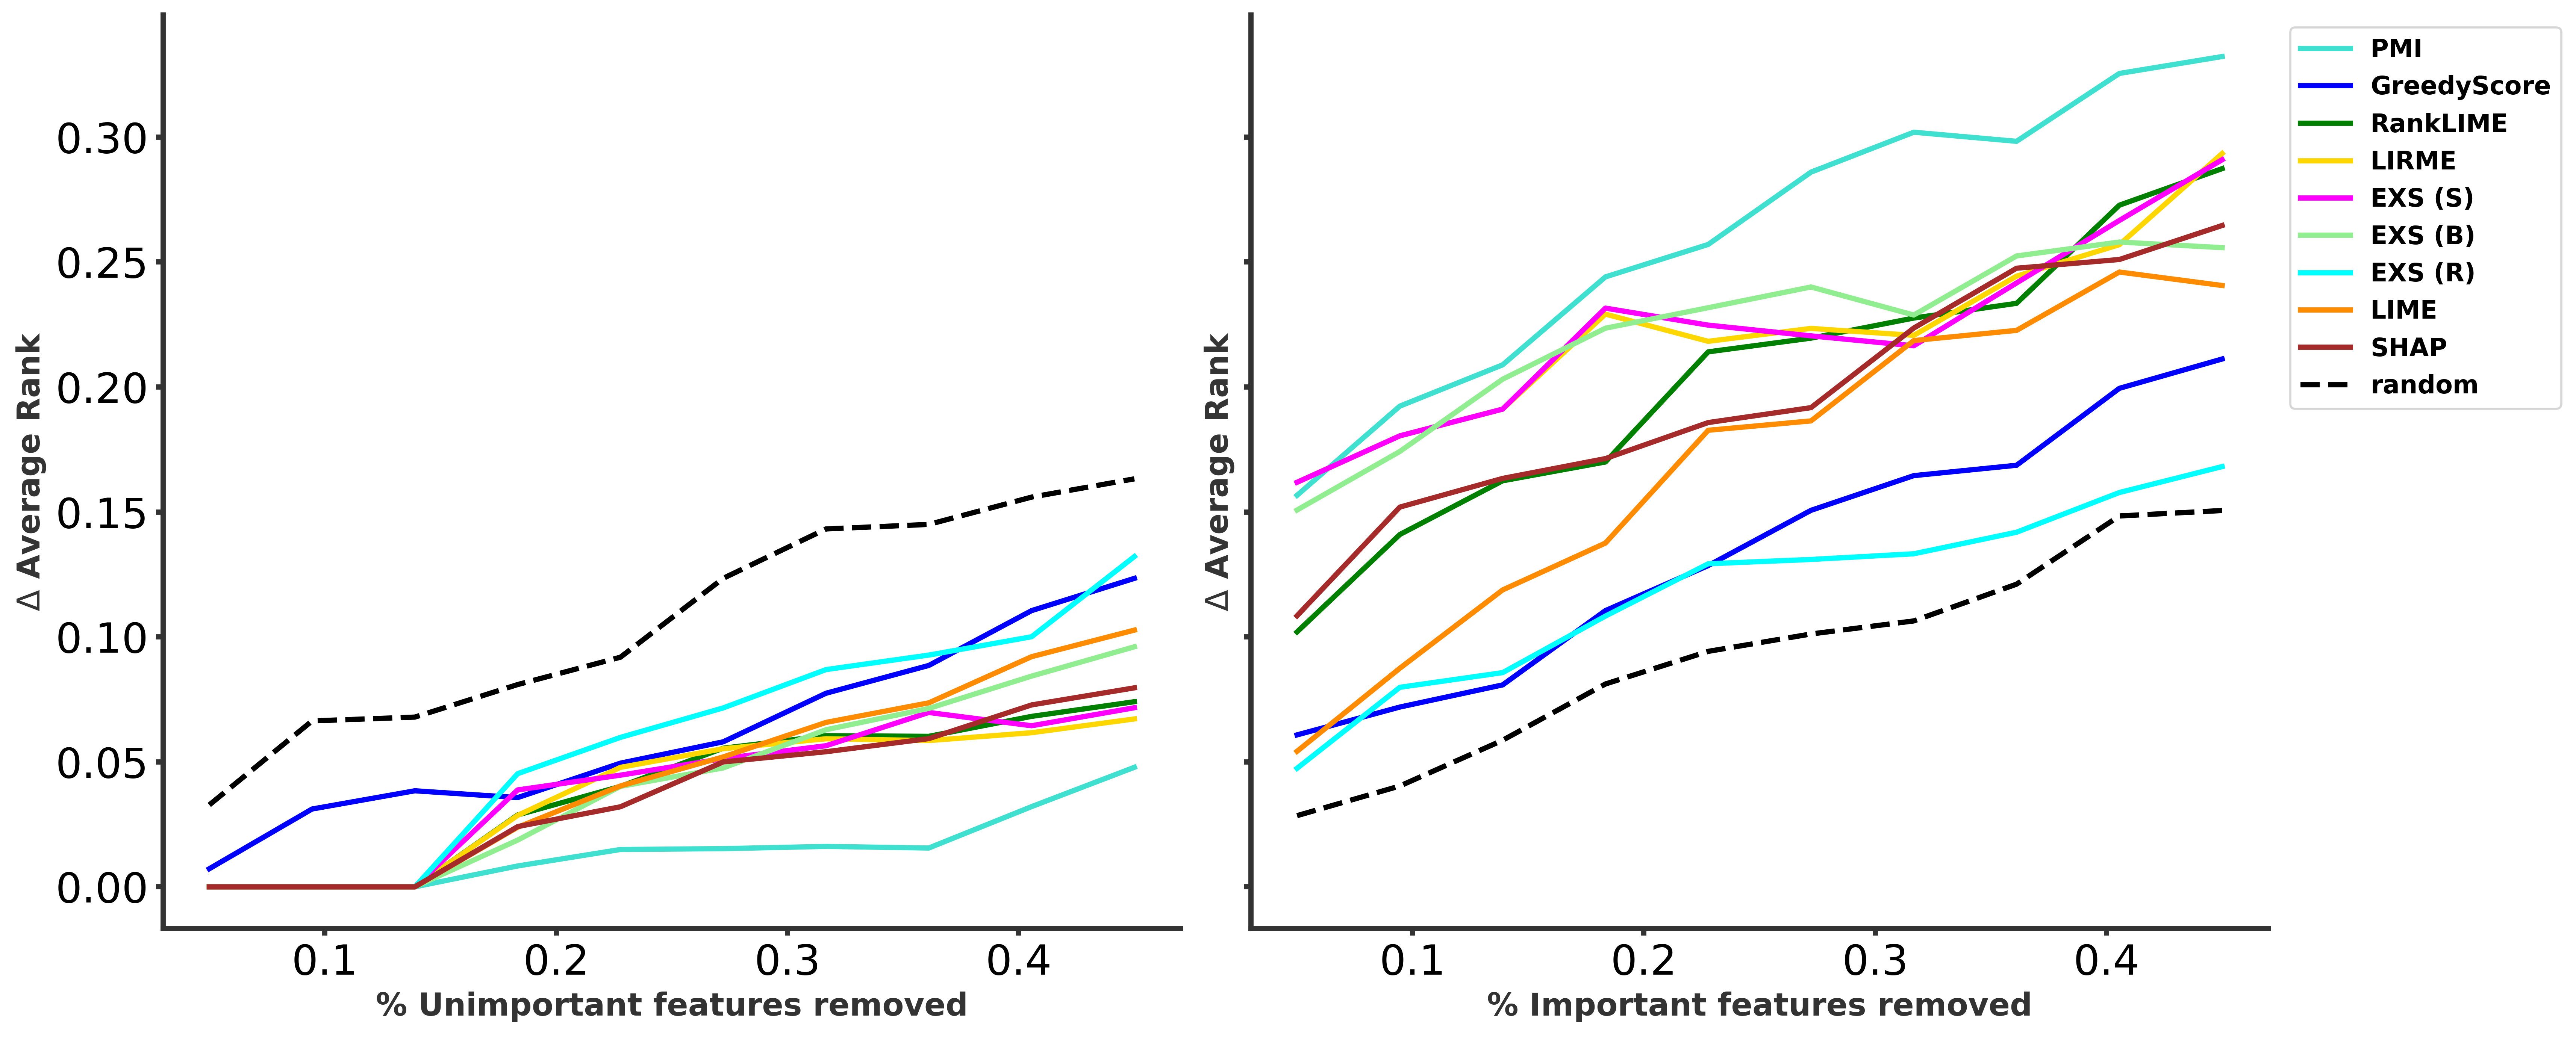

In [115]:
fig, ax = plt.subplots(1, 2, figsize=(17, 7), sharey=True, dpi=400)
cutoff = np.linspace(0.05, 0.45, 10)

subset_exps = ['pmi', 'greedy_score', 'rank_lime', 'lirme',
           'exs_score', 'exs_top_k_binary', 'exs_top_k_rank', 'lime', 'shap', 'random']
subset_exps_alt = np.array(['PMI', 'GreedyScore', 'RankLIME', 'LIRME', 'EXS (S)', 'EXS (B)', 'EXS (R)','LIME', 'SHAP', 'random'])

eval_ = pickle.load( open( f"./{dataset_name}_evaluate_summary_v3.p", "rb" ) ) 
for i in range(len(subset_exps)):
    e = subset_exps[i]
    
    #per = avg_per_cutoff(cutoff, robust['synthetic']['preservation'], e)
    per = np.array(eval_['validity'][e]).mean(axis=0)
    if i == len(subset_exps) - 1:
        ax[0].plot(cutoff, per, label=subset_exps_alt[i], color=color_list[e], 
                   linewidth=2.5, linestyle='dashed')
    else:
        ax[0].plot(cutoff, per, label=subset_exps_alt[i], color=color_list[e], 
                   linewidth=2.5)
    ax[0].set_xlabel('% Unimportant features removed', fontsize=20)
    ax[0].set_ylabel('$\Delta$ Average Rank')
    ax[0].tick_params(axis='both', which='major', labelsize=20)
    ax[0] = process_ax(ax[0])
    
    #dele = avg_per_cutoff(cutoff, robust['synthetic']['deletion'], e)
    dele = per = np.array(eval_['completeness'][e]).mean(axis=0)
    
    if i == len(subset_exps) - 1:
        ax[1].plot(cutoff, dele, label=subset_exps_alt[i], color=color_list[e], 
                   linewidth=2.5, linestyle='dashed')
    else:
        ax[1].plot(cutoff, dele, label=subset_exps_alt[i], color=color_list[e], linewidth=2.5)
    
    ax[1].tick_params(axis='both', which='major', labelsize=20)
    ax[1].set_xlabel('% Important features removed', fontsize=20)
    ax[1].set_ylabel('$\Delta$ Average Rank')
    ax[1] = process_ax(ax[1])

ax[1].legend(loc='upper right', prop = {'weight':'bold', 'size':12}, bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.savefig('./img/query_robustness_{}_v1.pdf'.format(dataset_name), bbox_inches='tight')

plt.show()

In [116]:
subset_exps = ['pmi', 'greedy_score', 'rank_lime', 'lirme',
           'exs_score', 'exs_top_k_binary', 'exs_top_k_rank', 'lime', 'shap']
subset_exps_alt = np.array(['PMI', 'GreedyScore', 'RankLIME', 'LIRME', 'EXS (S)', 'EXS (B)', 'EXS (R)','LIME', 'SHAP'])

" large agreement levels: 0.8 in MQ2008, 0.9 in Web10k, 0.9 in Yahoo

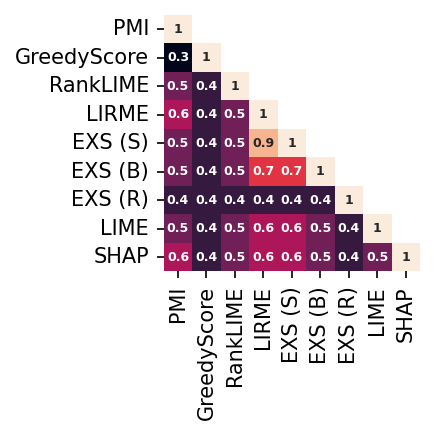

In [117]:
similarity = np.zeros((len(subset_exps), len(subset_exps)))
#top_ks = threshold_vals[z]
top_ks = 0.5
top_k = int(top_ks * background.shape[1])
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=150)

for i in range(0, len(subset_exps)):
    e_i = subset_exps[i]
    for j in range(i + 1):
        e_j = subset_exps[j]
        temp = []

        for k in range(len(queries)):
            first_exp = q_exps[queries[k]][e_i].flatten()
            second_exp = q_exps[queries[k]][e_j].flatten()

            ranked_first = np.argsort(np.abs(first_exp))[-top_k:][::-1]
            ranked_second = np.argsort(np.abs(second_exp))[-top_k:][::-1]

            f_exp_1 = np.zeros(background.shape[1])
            f_exp_1[ranked_first] = 1

            f_exp_2 = np.zeros(background.shape[1])
            f_exp_2[ranked_second] = 1

            temp.append(jaccard_score(np.abs(f_exp_1), np.abs(f_exp_2), average='binary'))
            #temp.append(kendalltau(np.abs(first_exp), np.abs(second_exp)).statistic)
        similarity[i][j] = np.nanmean(temp)

similarity[np.triu_indices(similarity.shape[0], +1)] = np.nan
sns.heatmap(similarity.round(1), xticklabels=subset_exps_alt, yticklabels=subset_exps_alt, 
    annot=True, annot_kws={"fontsize":6, 'fontweight':'bold'}, ax=ax, cbar=False)
plt.tight_layout()
plt.savefig('./img/pairwise_agrement_{}.pdf'.format(dataset_name))



### Rank Tables and Visualzations

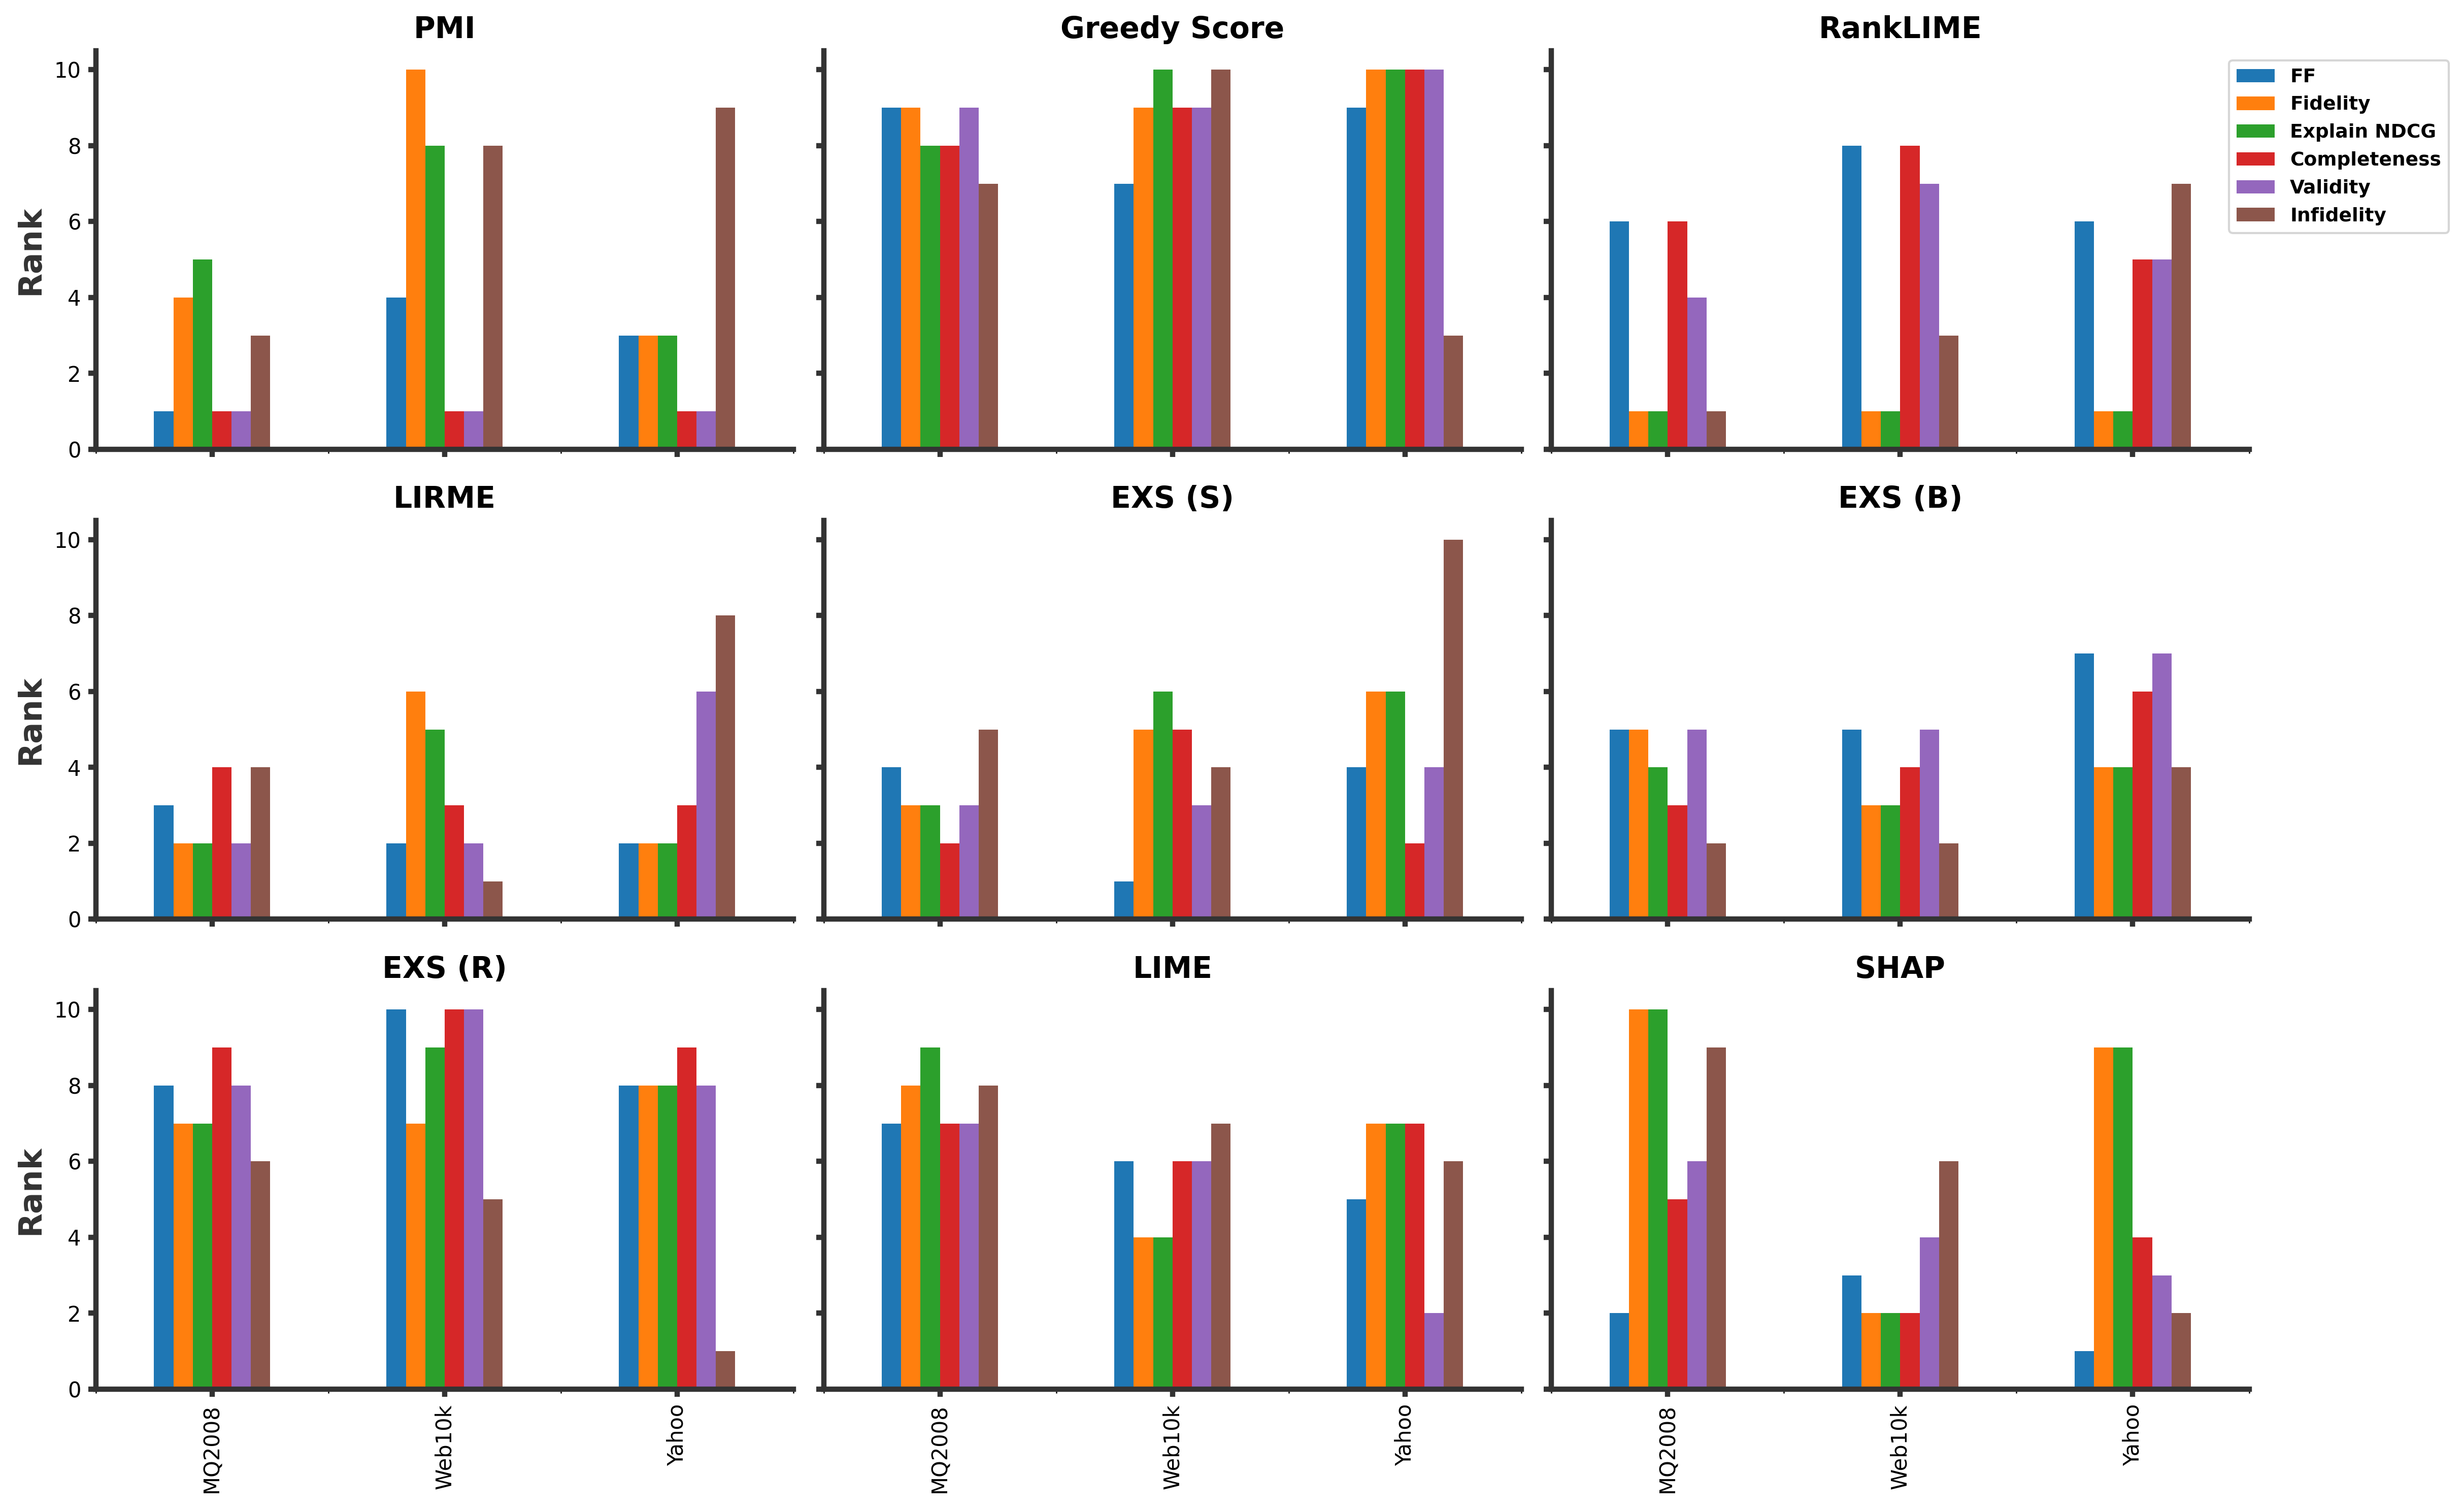

In [135]:
rank_results  = {}
fig, ax = plt.subplots(3, 3, figsize=(16, 10), dpi=300, sharex=True, sharey=True)
ax = ax.ravel()
#e_names = ['PMI', 'Greedy Score', 'RankLIME', 'LIRME', 'EXS (S)', 'EXS (B)', 'EXS (R)', 'LIME', 'SHAP', 'Random']
e_names = ['PMI', 'Greedy Score', 'RankLIME', 'LIRME', 'EXS (S)', 'EXS (B)', 'EXS (R)', 'LIME', 'SHAP']
for i in range(len(e_names)): 
    e = e_names[i]
    temp = []
    for d_names in ['mq2008', 'web10k', 'yahoo']: 
        summary_df_ = load_and_summarize(f"./{d_names}_evaluate_summary_v3.p")#.round(2)
        summary_df_rank_1 = summary_df_.iloc[:, :4].rank(ascending=False, axis=0)
        summary_df_rank_2 = summary_df_.iloc[:, 4:].rank(axis=0)
        summary_df_rank = pd.concat([summary_df_rank_1, summary_df_rank_2], axis=1) 

        temp.append(summary_df_rank.loc[e, :])
    
    rank_results[e] = pd.DataFrame(temp, index=['MQ2008', 'Web10k', 'Yahoo'])
    rank_results[e].plot.bar(ax=ax[i], legend=False)
    
    ax[i].set_title(e_names[i], fontsize=14, fontweight='bold')
    ax[i].set_ylabel('Rank')
    ax[i] = process_ax(ax[i])
    #ax[i].tick_params(axis='both', which='major', labelsize=12)
    #ax[i].set_xlabel(ax[i].get_xlabel(), fontsize = 13, weight = 'bold', color = '0.2')
    #ax[i].set_ylabel(ax[i].get_ylabel(), fontsize = 13, weight = 'bold', color = '0.2')
    
ax[2].legend(loc='upper right', prop = {'weight':'bold', 'size':9}, bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.savefig('./rank_overall_analysis.pdf')
plt.show()

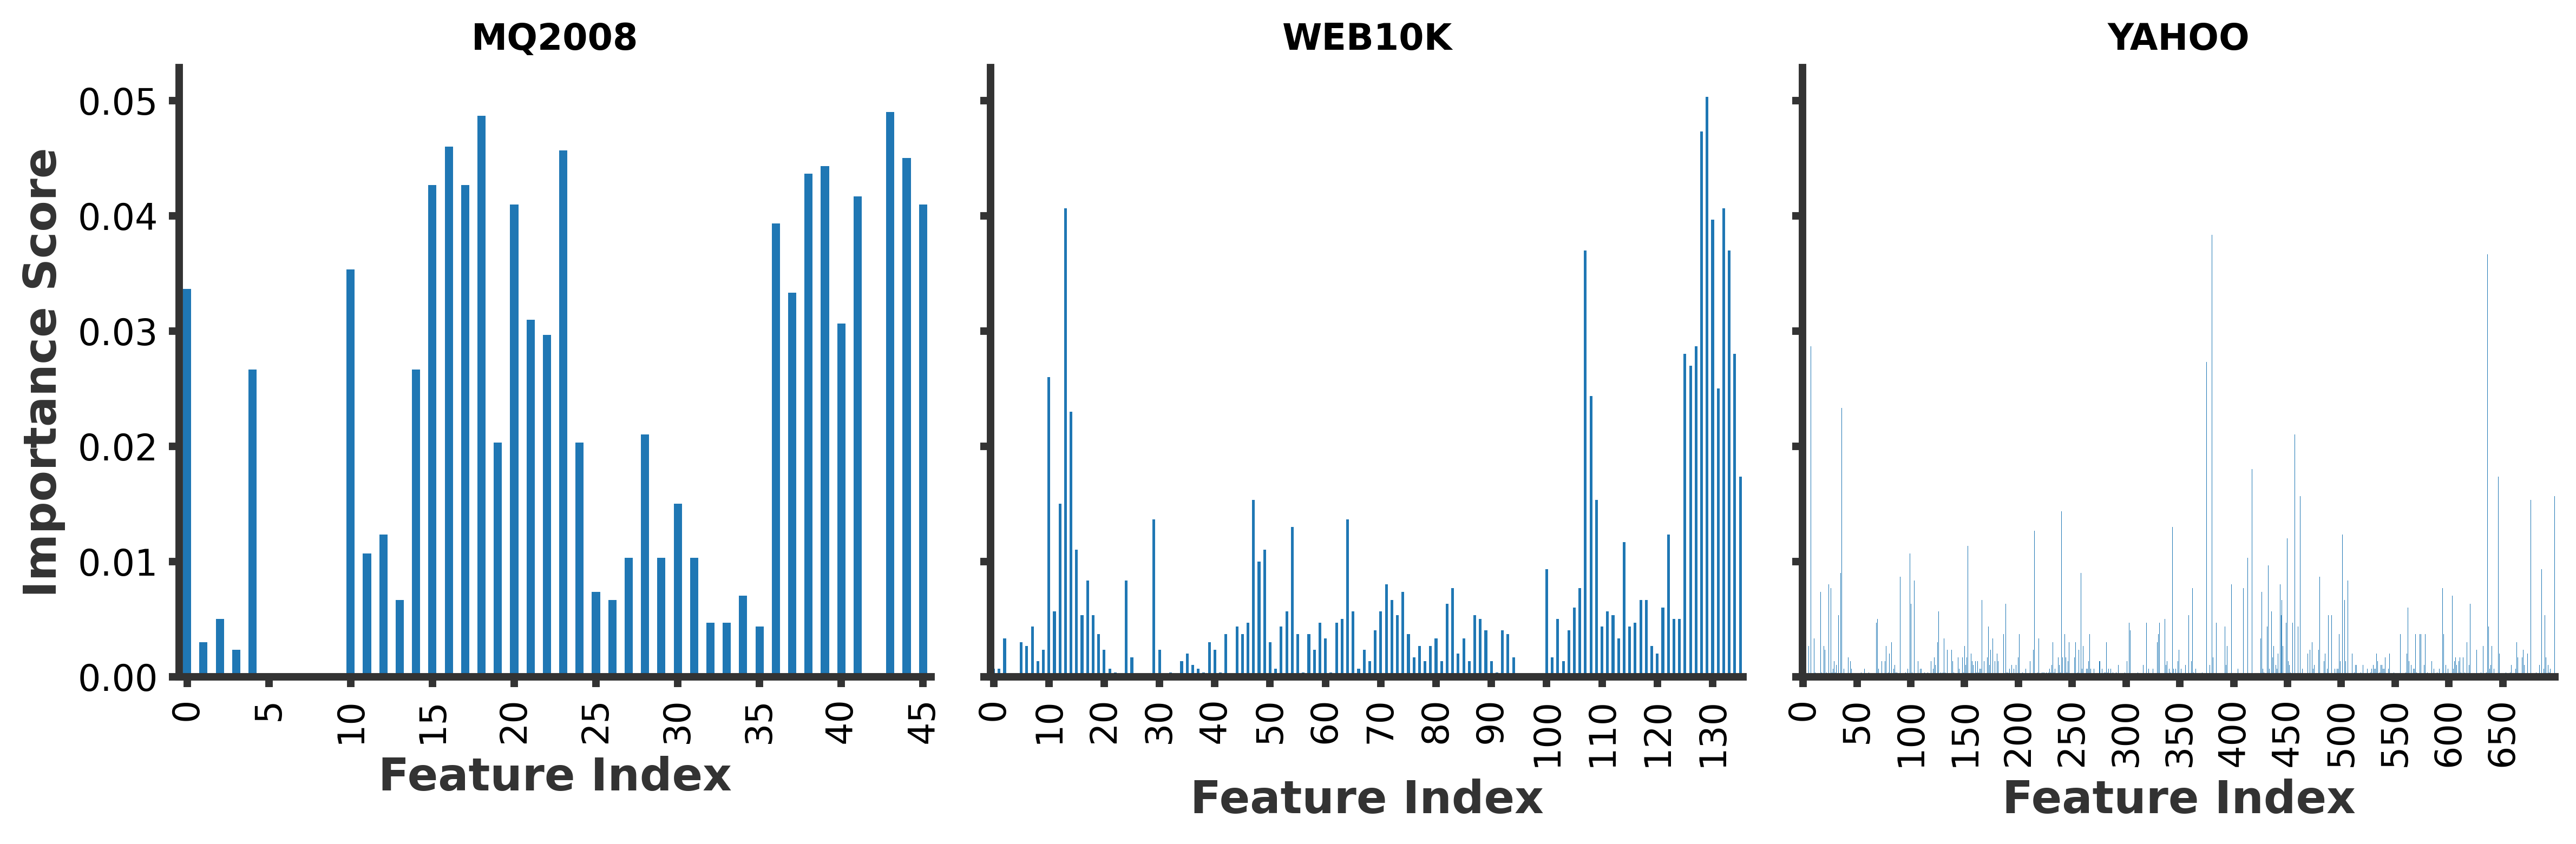

In [239]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=400, sharey=True)
d_names = ['mq2008', 'web10k', 'yahoo']

jump_cuts = [5, 10, 50]
for i in range(len(d_names)): 
    d_name = d_names[i]
    ranker = lightgbm.Booster(model_file='./models/lmart_{}_v2.txt'.format(d_name))
    feature_im_scores = pd.DataFrame(ranker.feature_importance() / np.sum(ranker.feature_importance()))
    x_values = feature_im_scores.index.values
    feature_im_scores.plot.bar(ax=ax[i], legend=False)
    ax[i].set_xticks(x_values[::jump_cuts[i]])
    ax[i].set_xticklabels(x_values[::jump_cuts[i]])
    ax[i].set_title(d_names[i].upper(),fontsize=12, fontweight='bold')
    ax[i] = process_ax(ax[i])
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    #ax[i].set_xlabel(ax[i].get_xlabel(), fontsize = 13, weight = 'bold', color = '1')
    #ax[i].set_ylabel(ax[i].get_ylabel(), fontsize = 13, weight = 'bold', color = '1')
    ax[i].set_ylabel('Importance Score')
    ax[i].set_xlabel('Feature Index')
plt.tight_layout()
plt.savefig('./global_feature_importance.pdf')

### Normalization effect 

In [77]:
res = pd.DataFrame()
for d_name in ['mq2008', 'web10k', 'yahoo']:
    summary_df = load_and_summarize(f"./{d_name}_evaluate_summary_v3_normalized.p")#.round(2)
    cols = []
    for c in summary_df.columns: 
        cols.append(f'{c} ({d_name})')
    summary_df.columns = cols
    res = pd.concat([res, summary_df.T.iloc[[1, 2, -1],:]])

In [97]:
res.round(2).style.highlight_min(axis=1)

,PMI,Greedy Score,RankLIME,LIRME,EXS (S),EXS (B),EXS (R),LIME,SHAP,Random
Fidelity (mq2008),0.660000,0.580000,0.690000,0.640000,0.650000,0.660000,0.580000,0.580000,0.570000,0.520000
Explain NDCG (mq2008),0.960000,0.940000,0.970000,0.960000,0.960000,0.970000,0.950000,0.940000,0.940000,0.930000
Infidelity (mq2008),-0.130000,-0.090000,-0.150000,-0.090000,-0.080000,-0.140000,0.030000,0.150000,0.080000,0.170000
Fidelity (web10k),-0.020000,0.020000,0.020000,0.020000,0.010000,0.020000,0.020000,0.020000,0.030000,0.000000
Explain NDCG (web10k),0.520000,0.560000,0.520000,0.550000,0.550000,0.550000,0.540000,0.520000,0.550000,0.530000
Infidelity (web10k),0.030000,0.050000,0.050000,-0.020000,-0.000000,-0.010000,0.040000,0.030000,0.010000,0.040000
Fidelity (yahoo),0.610000,0.470000,0.590000,0.470000,0.480000,0.490000,0.470000,0.500000,0.470000,0.480000
Explain NDCG (yahoo),0.950000,0.900000,0.940000,0.910000,0.910000,0.920000,0.910000,0.920000,0.900000,0.900000
Infidelity (yahoo),0.220000,0.100000,0.140000,0.260000,0.280000,0.210000,0.040000,0.130000,0.270000,0.080000


In [94]:
print(tabulate(res.round(2), tablefmt='latex_raw', headers=['PMI', 'Greedy Score', 'RankLIME', 'LIRME', 'EXS (S)', 'EXS (B)', 'EXS (R)', 'LIME', 'SHAP', 'Random']))

\begin{tabular}{lrrrrrrrrrr}
\hline
                       &   PMI &   Greedy Score &   RankLIME &   LIRME &   EXS (S) &   EXS (B) &   EXS (R) &   LIME &   SHAP &   Random \\
\hline
 Fidelity (mq2008)     &  0.66 &           0.58 &       0.69 &    0.64 &      0.65 &      0.66 &      0.58 &   0.58 &   0.57 &     0.52 \\
 Explain NDCG (mq2008) &  0.96 &           0.94 &       0.97 &    0.96 &      0.96 &      0.97 &      0.95 &   0.94 &   0.94 &     0.93 \\
 Infidelity (mq2008)   & -0.13 &          -0.09 &      -0.15 &   -0.09 &     -0.08 &     -0.14 &      0.03 &   0.15 &   0.08 &     0.17 \\
 Fidelity (web10k)     & -0.02 &           0.02 &       0.02 &    0.02 &      0.01 &      0.02 &      0.02 &   0.02 &   0.03 &     0    \\
 Explain NDCG (web10k) &  0.52 &           0.56 &       0.52 &    0.55 &      0.55 &      0.55 &      0.54 &   0.52 &   0.55 &     0.53 \\
 Infidelity (web10k)   &  0.03 &           0.05 &       0.05 &   -0.02 &     -0    &     -0.01 &      0.04 &   0.03 &   0.0